In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [13]:
# TODOs:
#     solve for displacements of a 2D truss system where each truss has only one element
#     create TrussElement2D(node_indeces, E,A,L, f=[0,0,0,0], theta = 0)
#         - k_elem 4x4



In [14]:
class TrussElement2D:
    def  __init__(self, node_indeces, node_coordinates, E,A,L, distributed_load = 0, f_applied=[0,0,0,0], theta = 0, shape_function = "linear"):
        self.node_indeces = node_indeces
        self.node_coordinates = node_coordinates
        self.E = E
        self.A = A
        self.L = L
        self.q = distributed_load
        self.f_applied = np.array(f_applied) # not necessary for current algorithm
        self.theta = theta # from (right) to (up)
        self.shape_function = shape_function

        if self.shape_function != "linear":
            raise NotImplementedError("Only linear shape functions are implemented")
        if self.q != 0:
            raise NotImplementedError("Distributed loads are not implemented")

        self.B = 1/self.L * np.array([-1, 0, 1, 0])

    def get_local_stiffness_matrix(self):
        # returns the stiffness matrix for the element in local coordinates
        k  = self.E*self.A/self.L
        self.k_elem_local = k * np.array([[1,0,-1,0],[0,0,0,0],[-1,0,1,0],[0,0,0,0]])

    def get_global_stiffness_matrix(self):
        self.get_local_stiffness_matrix()
        # returns the global stiffness matrix for the element in global coordinates
        S = np.sin(np.deg2rad(self.theta))
        C = np.cos(np.deg2rad(self.theta))
        self.R = np.array([[C, S],
                      [-S, C]])
        self.T = np.array([[C,S,0,0],
                      [-S,C,0,0],
                      [0,0,C,S],
                      [0,0,-S,C]])
        self.K_elem_global = self.T.T @ self.k_elem_local @ self.T
        return self.K_elem_global

    def get_local_load_vector(self):
        pass

    def get_global_load_vector(self):
        pass


In [15]:
class TrussSystem2D:
    def __init__(self, elements, num_nodes, forces, boundary_conditions):
        self.elements = elements
        self.num_nodes = num_nodes
        self.forces = forces
        self.boundary_conditions = boundary_conditions

    # def get_node_coordinates(self):
    #     origin = [0,0]

    #     for element in self.elements:
    #         for node_index in element.node_indeces:
    #             if node_index == 0:
    #                 node_coordinates = origin



In [16]:
class Solver:
    def __init__(self, system):
        self.system = system

    def solve(self):
        K_global, F_global = self.assemble_global_matrices()
        Kuu, Fuu = self.apply_boundary_conditions()
        displacements = self.solve_displacements()
        stresses = self.calculate_stresses()

        return self.displacements, self.stresses

    def assemble_global_matrices(self):
        # Assemble global stiffness
        self.K_global = np.zeros((self.system.num_nodes*2, self.system.num_nodes*2)) # multiply by 2 cause for a node 2 is the DoF hence it's 2D

        for element in self.system.elements:
            K_elem = element.get_global_stiffness_matrix()
            node_per_element = len(self.system.elements[0].node_indeces) # 2 for linear

            # Get the global DOF indices for the element's nodes
            global_dof_indices = []
            for node_index in element.node_indeces:
                global_dof_indices.extend([2 * node_index, 2 * node_index + 1])  # DOFs: x, y

            for i in range(len(global_dof_indices)):
                for j in range(len(global_dof_indices)):
                    self.K_global[global_dof_indices[i], global_dof_indices[j]] += K_elem[i, j]

        # Assemble load vector
        self.F_global = np.zeros((self.system.num_nodes*2))
        for node_index, f_x, f_y in self.system.forces:
            global_dof_index = int(2 * node_index)
            self.F_global[global_dof_index] += f_x
            self.F_global[global_dof_index + 1] += f_y

        return self.K_global, self.F_global

    def apply_boundary_conditions(self):
        known_global_indeces = []
        for node_index, constraint_x, constraint_y in self.system.boundary_conditions:
            global_dof_index = int(2 * node_index)
            if constraint_x == 1:
                known_global_indeces.append(global_dof_index)
            if constraint_y == 1:
                known_global_indeces.append(global_dof_index + 1)
        self.known_global_indeces = known_global_indeces

        # get the matrix while remowing the indeces in known global indeces
        self.Kuu = np.delete(np.delete(self.K_global, known_global_indeces, axis=0), known_global_indeces, axis=1)
        self.Fuu = np.delete(self.F_global, known_global_indeces, axis=0)

        return self.Kuu, self.Fuu

    def solve_displacements(self):
        self.Duu = np.linalg.solve(self.Kuu, self.Fuu) # unknown displacements

        # merge known and unknown displacements based on self.known_global_indeces
        unknown_global_indeces = [i for i in range(self.system.num_nodes*2) if i not in self.known_global_indeces]
        self.displacements = np.zeros((self.system.num_nodes*2))
        self.displacements[unknown_global_indeces] = self.Duu

        return self.displacements


    def calculate_stresses(self):
        self.stresses = np.zeros(len(self.system.elements))
        for i, element in enumerate(self.system.elements):
            # get displacements for each node
            displacement_1 = self.displacements[2*element.node_indeces[0]:2*element.node_indeces[0]+2]
            displacement_2 = self.displacements[2*element.node_indeces[1]:2*element.node_indeces[1]+2]
            D_elem_global = np.array([displacement_1, displacement_2]).flatten() # global displacement vector for element
            d_elem_local = element.T @ D_elem_global  # local displacement vector for element
            self.stresses[i] = element.E * element.B @ d_elem_local

        return self.stresses


In [17]:
class Plotter:
    def __init__(self, solver):
        self.system = solver.system
        self.displacements = solver.displacements
        self.stresses = solver.stresses

    def plot_system(self):
        """
        plots the truss system
        """
        for i, element in enumerate(self.system.elements):
            pos1, pos2 = element.node_coordinates
            node_index1, node_index2 = element.node_indeces
            offset = 30 # for text

            # PLOT INITIAL SYSTEM
            x1, y1 = pos1
            x2, y2 = pos2
            plt.scatter([x1,x2], [y1,y2],c="r")
            plt.plot([x1,x2], [y1,y2],c="r")
            plt.text(x1+offset, y1+offset, node_index1, color="r")
            plt.text(x2+offset, y2+offset, node_index2, color="r")


            # PLOT SYSTEM WITH DISPLACEMENTS
            x1_disp, y1_disp = pos1 + self.displacements[2*node_index1:2*node_index1+2]
            x2_disp, y2_disp = pos2 + self.displacements[2*node_index2:2*node_index2+2]
            plt.scatter([x1_disp,x2_disp], [y1_disp,y2_disp],c="b")
            plt.plot([x1_disp,x2_disp], [y1_disp,y2_disp],c="b", linestyle="--")
            plt.text(x1_disp+offset, y1_disp+offset, node_index1, color="b")
            plt.text(x2_disp+offset, y2_disp+offset, node_index2, color="b")


            # PLOT ELEMENT INTERNAL FORCES
            x_mid = x1_disp + (x2_disp - x1_disp) * 0.5
            y_mid = y1_disp + (y2_disp - y1_disp) * 0.5
            plt.text(x_mid, y_mid, f"{self.stresses[i]/1000*element.A:.2f} kN", color="black")


        plt.title("Truss System")
        plt.xlabel("x [mm]")
        plt.ylabel("y [mm]")
        plt.show()


In [18]:
# Add mesh generator like: https://youtu.be/kIiVQirjvyo?si=PuONgxOkn9lBsPu1&t=1994

In [30]:
E = 100*10^3; A = 625; L=2000; # for each truss element, [units: N, mm, MPa]

connectivity = np.array([[0,1], [0,2], [1,2], [1,3], [2,3], [2,4], [3,4]])
nodal_coordinates = np.array([[0,0], [0,L], [L,0], [L,L], [2*L,0]])

# node_index, constraint_x, constraint_y
boundary_conditions = np.array([
                            [0,1,0],
                            [1,1,1]])

 # node_index, f_x, f_y
forces = np.array([
                [0, 100e3, 0], # reaction 1
                [1, -200e3, 100e3], # reaction 2
                [4, 100e3, -100e3]])  # applied force

num_nodes = (np.max(connectivity) + 1)
elements = []
for i, node_indeces in enumerate(connectivity):
    node_coordinates = nodal_coordinates[node_indeces]

    # Extract coordinates
    x1, y1 = node_coordinates[0]
    x2, y2 = node_coordinates[1]

    # Calculate length
    L = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # Calculate angle in radians
    theta = np.rad2deg(np.arctan2(y2 - y1, x2 - x1))

    element = TrussElement2D(node_indeces, node_coordinates, E,A,L,theta=theta)
    elements.append(element)

system = TrussSystem2D(elements, num_nodes, forces, boundary_conditions)


90.0 2000.0
0.0 2000.0
-45.0 2828.42712474619
0.0 2000.0
90.0 2000.0
0.0 2000.0
-45.0 2828.42712474619


In [31]:
solver = Solver(system)
solver.solve()

(array([    0.        ,     0.        ,     0.        ,     0.        ,
         -319.04287139, -1221.43238277,   319.04287139, -1540.47525416,
         -319.04287139, -3080.95050831]),
 array([ 0.00000000e+00, -1.60000000e+02,  2.26274170e+02,  1.60000000e+02,
        -1.60000000e+02, -2.84217094e-14,  2.26274170e+02]))

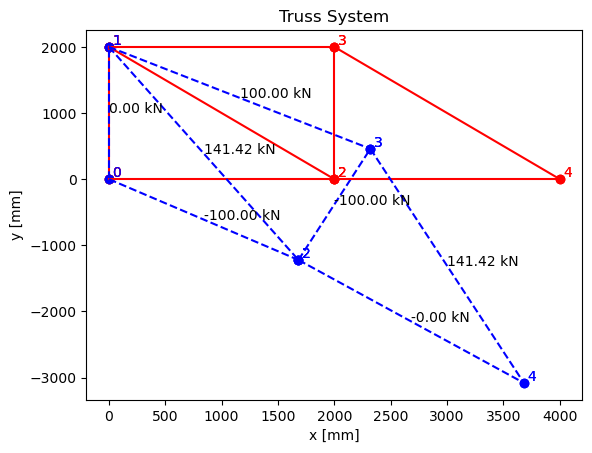

In [32]:
plotter = Plotter(solver)
plotter.plot_system()
